In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb

df = pd.read_csv('AmesHousing.csv', sep='\t')
pd.set_option('display.max_columns', None)
new_df = df.assign(hasBasement = df['Total Bsmt SF'] > 0)
new_df = new_df.assign(hasGarage = df['Garage Area'] > 0)
new_df = new_df.assign(hasFireplace = df['Fireplaces'] > 0)
new_df = new_df.assign(hasPool = df['Pool Area'] > 0)
new_df = new_df.assign(TotalSF = (df['Total Bsmt SF'].fillna(0) + df['Gr Liv Area'].fillna(0)))
new_df = new_df.assign(TotalBath = (df['Bsmt Full Bath'].fillna(0) + 0.5 * df['Bsmt Half Bath'].fillna(0) + 
                                    df['Full Bath'].fillna(0) + 0.5 * df['Half Bath'].fillna(0)))
new_df = new_df.assign(TotalPorchSF = df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
new_df = new_df.assign(Positive_Off_Site = (df['Condition 2'] == 'PosN') | (df['Condition 2'] == 'PosA'))
new_df = new_df.assign(hasFence = df['Fence'].notnull())
new_df.drop(columns=['Total Bsmt SF', 'Fireplaces',
                      'Pool Area', 'Bsmt Exposure', 'Bsmt Half Bath',
                        'Bsmt Full Bath', 'BsmtFin Type 1', 'BsmtFin Type 2',
                          'Bsmt Exposure', 'Lot Config', 'Condition 2',
                            'Garage Type', 'Garage Finish', 'Garage Qual',
                              'Pool QC', 'Fence', 'Lot Shape', 'Land Slope',
                                'Fireplace Qu', 'Yr Sold',
                                  'Mo Sold', 'Order', '1st Flr SF', '2nd Flr SF'
                                  , 'Garage Yr Blt', 'Garage Cond', 'Wood Deck SF'
                                  , 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
                                  'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF']
                                    ,inplace=True)
new_df = new_df[new_df['Electrical'].notnull()]


print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2929 entries, 0 to 2929
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PID                2929 non-null   int64  
 1   MS SubClass        2929 non-null   int64  
 2   MS Zoning          2929 non-null   object 
 3   Lot Frontage       2439 non-null   float64
 4   Lot Area           2929 non-null   int64  
 5   Street             2929 non-null   object 
 6   Alley              198 non-null    object 
 7   Land Contour       2929 non-null   object 
 8   Utilities          2929 non-null   object 
 9   Neighborhood       2929 non-null   object 
 10  Condition 1        2929 non-null   object 
 11  Bldg Type          2929 non-null   object 
 12  House Style        2929 non-null   object 
 13  Overall Qual       2929 non-null   int64  
 14  Overall Cond       2929 non-null   int64  
 15  Year Built         2929 non-null   int64  
 16  Year Remod/Add     2929 non-n

In [214]:
price_quartiles = new_df['SalePrice'].quantile([0.25, 0.5, 0.75])
print("\nPrice Quartiles:")
print(f"Q1 (25%): ${price_quartiles[0.25]:,.0f}")
print(f"Q2 (50%): ${price_quartiles[0.5]:,.0f}")
print(f"Q3 (75%): ${price_quartiles[0.75]:,.0f}")

def categorize_price(price):
    if price < price_quartiles[0.25]:
        return 'Low'
    elif price < price_quartiles[0.5]:
        return 'Medium-Low'
    elif price < price_quartiles[0.75]:
        return 'Medium-High'
    else:
        return 'High'

new_df['PriceCategory'] = new_df['SalePrice'].apply(categorize_price)
print(new_df['PriceCategory'].value_counts().sort_index())


Price Quartiles:
Q1 (25%): $129,500
Q2 (50%): $160,000
Q3 (75%): $213,500
PriceCategory
High           734
Low            731
Medium-High    751
Medium-Low     713
Name: count, dtype: int64


In [215]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

X = new_df.drop(columns=['SalePrice', 'PriceCategory', 'PID'])
y = new_df['PriceCategory']

X_cat = X.copy()
categorical_cols = X_cat.select_dtypes(include=['object']).columns
bool_cols = X_cat.select_dtypes(include=['bool']).columns
X_cat[bool_cols] = X_cat[bool_cols].astype('object')

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

X[bool_cols] = X[bool_cols].astype(int)

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print(f"Class labels: {y_encoder.classes_}")


Number of features: 55
Number of classes: 4
Class labels: ['High' 'Low' 'Medium-High' 'Medium-Low']


In [216]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(
    X, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train_10.shape[0]}")
print(f"Test set: {X_test_10.shape[0]}")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train_10, return_counts=True)
for cls, cnt in zip(y_encoder.classes_, counts):
    print(f"{cls}: {cnt} ({cnt/len(y_train_10)*100:.1f}%)")

xgb_model_10_strat = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model_10_strat.fit(X_train_10, y_train_10)
y_pred_10_strat = xgb_model_10_strat.predict(X_test_10)

print(f"\nAccuracy:  {accuracy_score(y_test_10, y_pred_10_strat):.4f}")
print(f"Precision: {precision_score(y_test_10, y_pred_10_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_10, y_pred_10_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_10, y_pred_10_strat, average='weighted'):.4f}")


Training set: 2636
Test set: 293

Class distribution in training set:
High: 660 (25.0%)
Low: 658 (25.0%)
Medium-High: 676 (25.6%)
Medium-Low: 642 (24.4%)

Accuracy:  0.7884
Precision: 0.7907
Recall:    0.7884
F1 Score:  0.7891

Accuracy:  0.7884
Precision: 0.7907
Recall:    0.7884
F1 Score:  0.7891


In [217]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train_20.shape[0]}")
print(f"Test set: {X_test_20.shape[0]}")

print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train_20, return_counts=True)
for cls, cnt in zip(y_encoder.classes_, counts):
    print(f"{cls}: {cnt} ({cnt/len(y_train_20)*100:.1f}%)")

xgb_model_20_strat = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model_20_strat.fit(X_train_20, y_train_20)
y_pred_20_strat = xgb_model_20_strat.predict(X_test_20)

print(f"\nAccuracy:  {accuracy_score(y_test_20, y_pred_20_strat):.4f}")
print(f"Precision: {precision_score(y_test_20, y_pred_20_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_20, y_pred_20_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_20, y_pred_20_strat, average='weighted'):.4f}")


Training set: 2343
Test set: 586

Class distribution in training set:
High: 587 (25.1%)
Low: 585 (25.0%)
Medium-High: 601 (25.7%)
Medium-Low: 570 (24.3%)

Accuracy:  0.8072
Precision: 0.8056
Recall:    0.8072
F1 Score:  0.8062

Accuracy:  0.8072
Precision: 0.8056
Recall:    0.8072
F1 Score:  0.8062


In [218]:
X_train_20_no, X_test_20_no, y_train_20_no, y_test_20_no = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=None
)

print(f"\nClass distribution in training set (no stratification):")
unique, counts = np.unique(y_train_20_no, return_counts=True)
for cls, cnt in zip(y_encoder.classes_, counts):
    print(f"  {cls}: {cnt} ({cnt/len(y_train_20_no)*100:.1f}%)")

xgb_model_20_no_strat = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model_20_no_strat.fit(X_train_20_no, y_train_20_no)
y_pred_20_no_strat = xgb_model_20_no_strat.predict(X_test_20_no)

print(f"\nAccuracy:  {accuracy_score(y_test_20_no, y_pred_20_no_strat):.4f}")
print(f"Precision: {precision_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")


Class distribution in training set (no stratification):
  High: 587 (25.1%)
  Low: 583 (24.9%)
  Medium-High: 615 (26.2%)
  Medium-Low: 558 (23.8%)

Accuracy:  0.8294
Precision: 0.8312
Recall:    0.8294
F1 Score:  0.8298

Accuracy:  0.8294
Precision: 0.8312
Recall:    0.8294
F1 Score:  0.8298


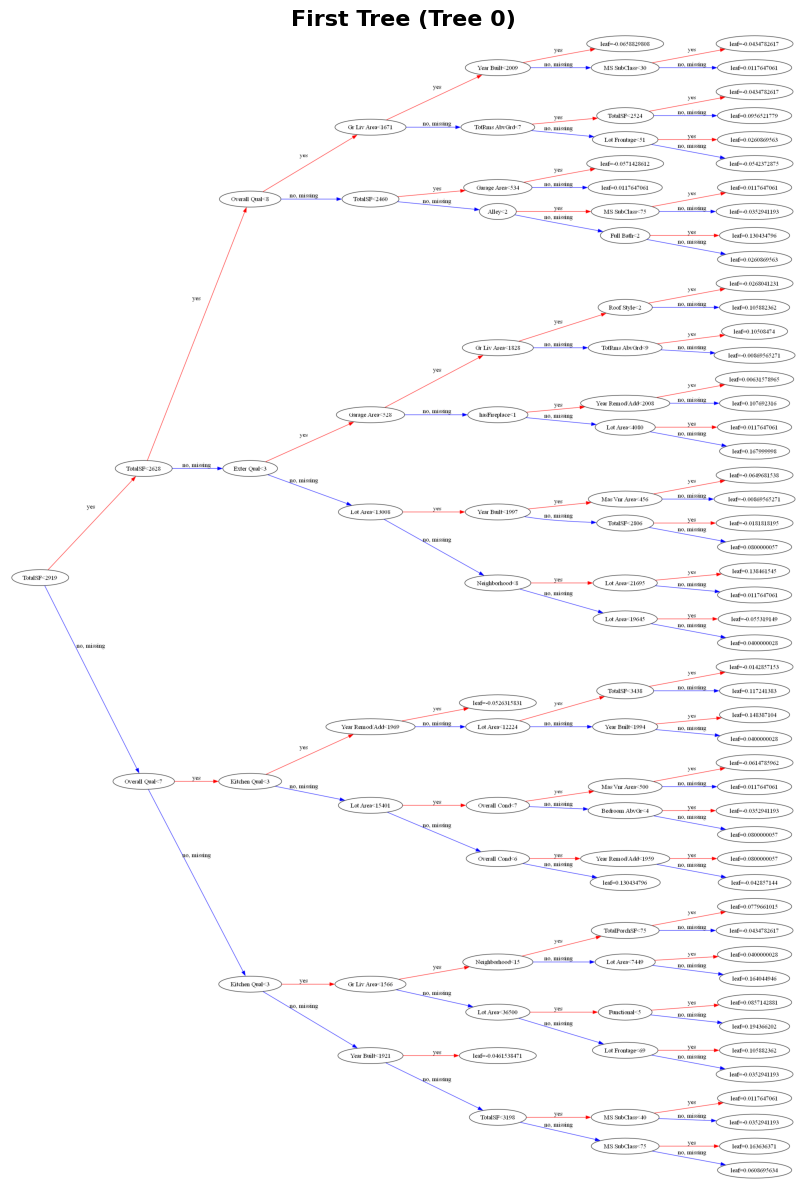

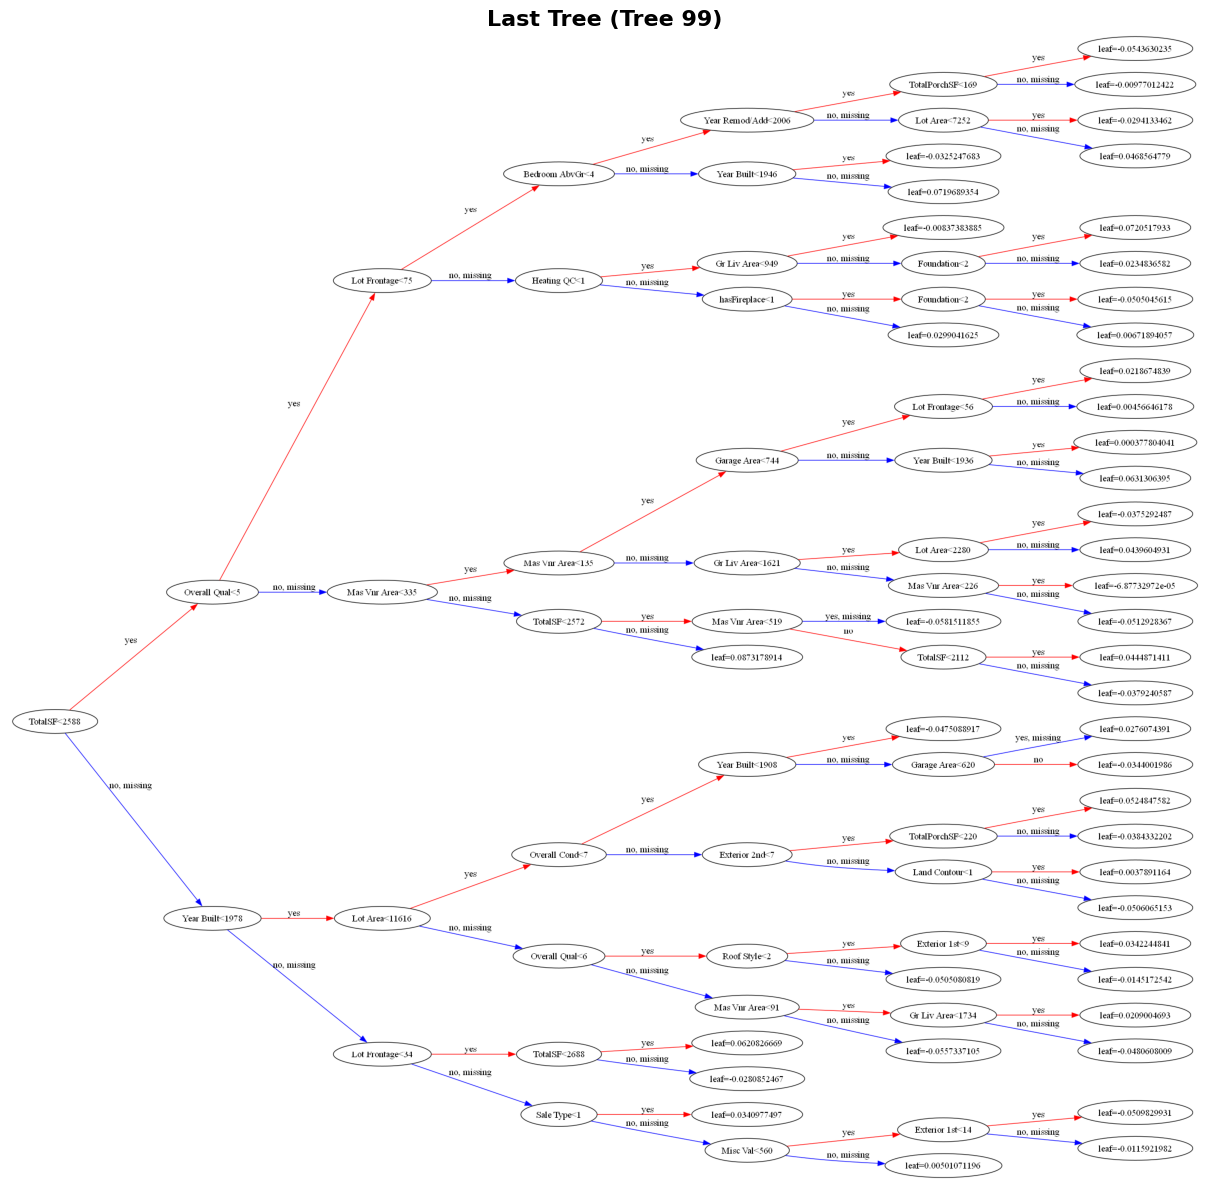

In [219]:
booster = xgb_model_20_strat.get_booster()

fig, ax = plt.subplots(figsize=(20, 12))
xgb.plot_tree(booster, tree_idx=0, ax=ax, rankdir='LR')
plt.title('First Tree (Tree 0)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('first_tree.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

num_trees = xgb_model_20_strat.get_booster().num_boosted_rounds()
fig, ax = plt.subplots(figsize=(20, 12))
xgb.plot_tree(booster, tree_idx=num_trees-1, ax=ax, rankdir='LR')
plt.title(f'Last Tree (Tree {num_trees-1})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('last_tree.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

      Feature  Importance
      TotalSF    0.103664
 Overall Qual    0.073096
   Exter Qual    0.061692
    Full Bath    0.058480
 Kitchen Qual    0.054555
   Year Built    0.048169
  Garage Cars    0.033226
 hasFireplace    0.031086
Kitchen AbvGr    0.028321
    MS Zoning    0.027864
  Gr Liv Area    0.025512
    TotalBath    0.022533
     Lot Area    0.018684
 Overall Cond    0.018652
  House Style    0.018266


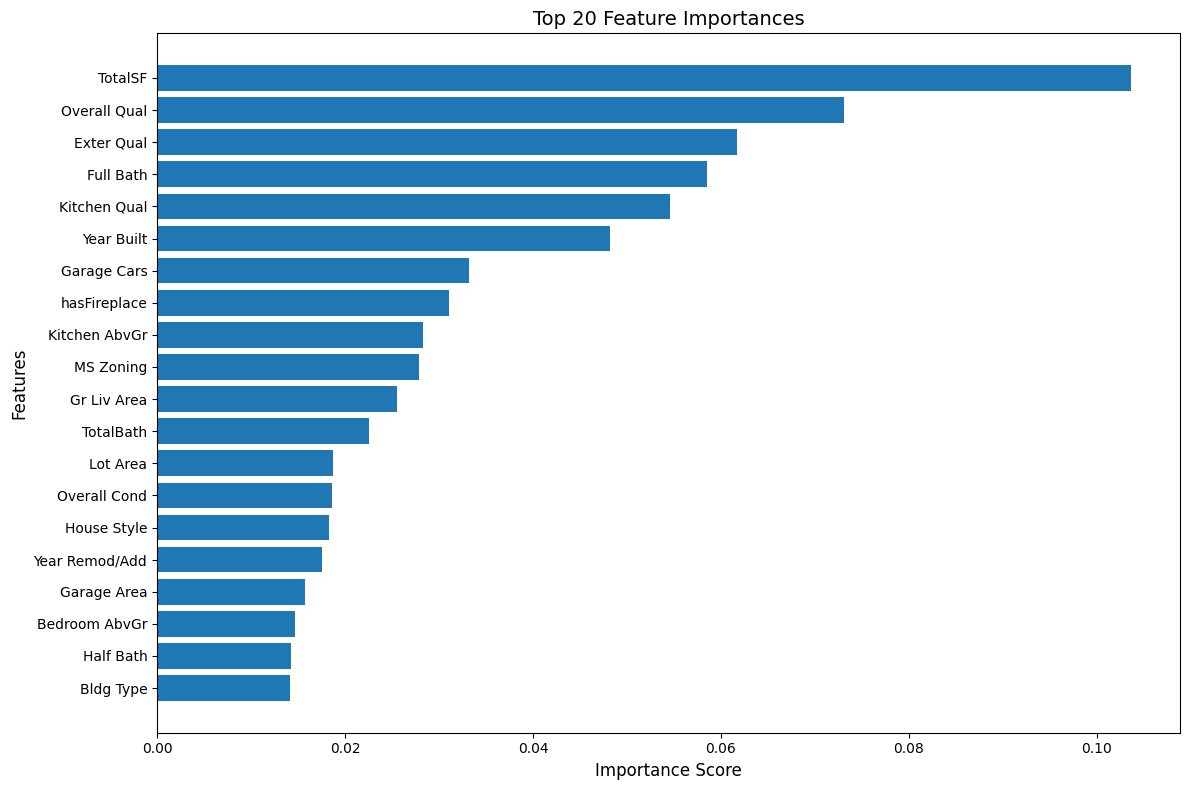

In [220]:
feature_importance = xgb_model_20_no_strat.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(importance_df.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_n = 20
top_features = importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top {top_n} Feature Importances', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

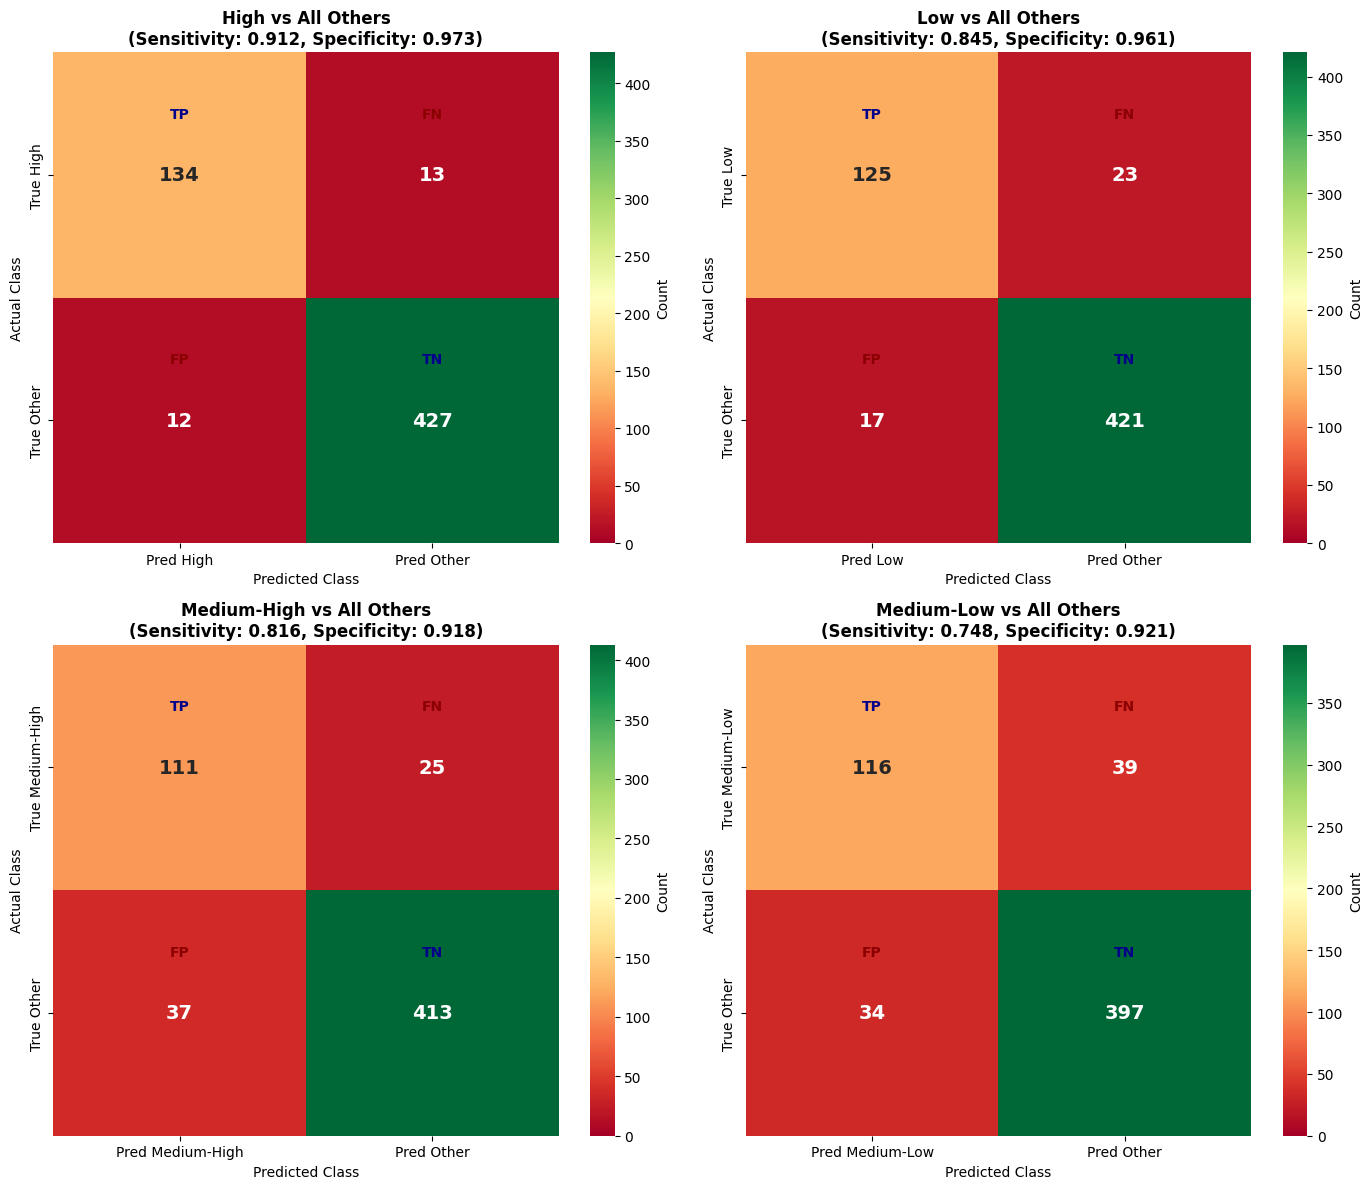

In [221]:
def calculate_binary_metrics(y_true, y_pred, class_idx, class_name):
    y_true_binary = (y_true == class_idx).astype(int)
    y_pred_binary = (y_pred == class_idx).astype(int)
    
    tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    
    return tp, fp, fn, tn

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, class_name in enumerate(y_encoder.classes_):
    tp, fp, fn, tn = calculate_binary_metrics(y_test_20_no, y_pred_20_no_strat, idx, class_name)
    binary_cm = np.array([[tp, fn], [fp, tn]])
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sns.heatmap(binary_cm, annot=True, fmt='d', cmap='RdYlGn', ax=axes[idx],
                xticklabels=[f'Pred {class_name}', 'Pred Other'],
                yticklabels=[f'True {class_name}', 'True Other'],
                cbar_kws={'label': 'Count'}, vmin=0, vmax=max(tp, fp, fn, tn),
                annot_kws={'size': 14, 'weight': 'bold'})
    
    axes[idx].text(0.5, 0.25, 'TP', ha='center', va='center', 
                   fontsize=10, color='darkblue', weight='bold')
    axes[idx].text(1.5, 0.25, 'FN', ha='center', va='center', 
                   fontsize=10, color='darkred', weight='bold')
    axes[idx].text(0.5, 1.25, 'FP', ha='center', va='center', 
                   fontsize=10, color='darkred', weight='bold')
    axes[idx].text(1.5, 1.25, 'TN', ha='center', va='center', 
                   fontsize=10, color='darkblue', weight='bold')
    
    axes[idx].set_title(f'{class_name} vs All Others\n(Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f})', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual Class', fontsize=10)
    axes[idx].set_xlabel('Predicted Class', fontsize=10)

plt.tight_layout()
plt.show()


In [222]:
print(classification_report(y_test_20_no, y_pred_20_no_strat, target_names=y_encoder.classes_))

              precision    recall  f1-score   support

        High       0.92      0.91      0.91       147
         Low       0.88      0.84      0.86       148
 Medium-High       0.75      0.82      0.78       136
  Medium-Low       0.77      0.75      0.76       155

    accuracy                           0.83       586
   macro avg       0.83      0.83      0.83       586
weighted avg       0.83      0.83      0.83       586



The model seems to excel at identifying highly and low priced properties.

The high pricing houses could possibly be easily identified by different distinct properties like: a lot of sqaure feet, a pool, a fireplace, being newly constructed/ newly remodeled.

Cheaper houses could have the opposite effect like having very few appliances, being in worse neighborhoods, having few square feet.

The model struggles with the medium priced households more(in all possible metrics). This could be because middling properties don't have distinct features that can distinguish from one and another. They can depend a lot on the specific property and here prices are prone to fluctuating. 


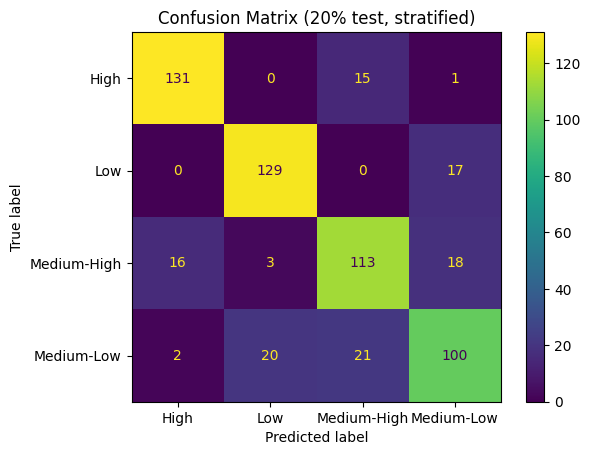

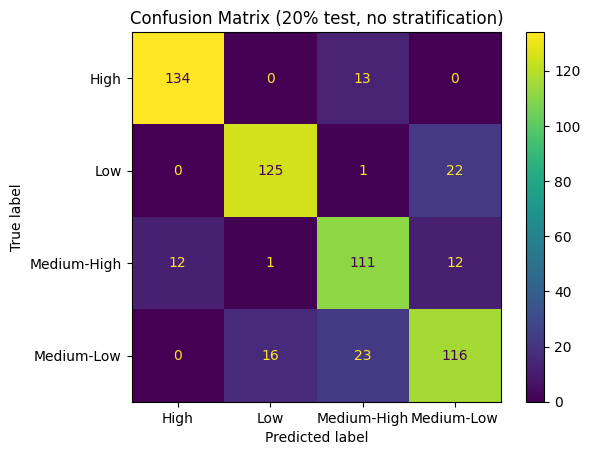

In [223]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test_20, y_pred_20_strat,
    display_labels=y_encoder.classes_
)
plt.title('Confusion Matrix (20% test, stratified)')
plt.show()

ConfusionMatrixDisplay.from_predictions(
    y_test_20_no, y_pred_20_no_strat,
    display_labels=y_encoder.classes_
)
plt.title('Confusion Matrix (20% test, no stratification)')
plt.show()

In [224]:
from sklearn.model_selection import cross_validate, KFold

clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

print("5-fold (unstratified) CV:")
cv5_unstrat = cross_validate(clf, X, y_encoded, cv=KFold(5, shuffle=True, random_state=42), scoring=scoring)
for m in scoring:
    print(f"{m}: {cv5_unstrat[f'test_{m}'].mean():.4f} ± {cv5_unstrat[f'test_{m}'].std():.4f}")

print("\n10-fold (unstratified) CV:")
cv10_unstrat = cross_validate(clf, X, y_encoded, cv=KFold(10, shuffle=True, random_state=42), scoring=scoring)
for m in scoring:
    print(f"{m}: {cv10_unstrat[f'test_{m}'].mean():.4f} ± {cv10_unstrat[f'test_{m}'].std():.4f}")

5-fold (unstratified) CV:
accuracy: 0.7887 ± 0.0206
precision_weighted: 0.7925 ± 0.0203
recall_weighted: 0.7887 ± 0.0206
f1_weighted: 0.7895 ± 0.0205

10-fold (unstratified) CV:
accuracy: 0.7887 ± 0.0206
precision_weighted: 0.7925 ± 0.0203
recall_weighted: 0.7887 ± 0.0206
f1_weighted: 0.7895 ± 0.0205

10-fold (unstratified) CV:
accuracy: 0.7969 ± 0.0238
precision_weighted: 0.7997 ± 0.0251
recall_weighted: 0.7969 ± 0.0238
f1_weighted: 0.7968 ± 0.0245
accuracy: 0.7969 ± 0.0238
precision_weighted: 0.7997 ± 0.0251
recall_weighted: 0.7969 ± 0.0238
f1_weighted: 0.7968 ± 0.0245


The 10-fold Cross validation seems to have overall higher values. The multiple training and validation iterations could be the most likely reason for this increase in performance.

Shape after one-hot encoding: (2929, 196)
Accuracy:  0.7969
Precision: 0.7967
Recall:    0.7969
F1 Score:  0.7967
Accuracy:  0.7969
Precision: 0.7967
Recall:    0.7969
F1 Score:  0.7967


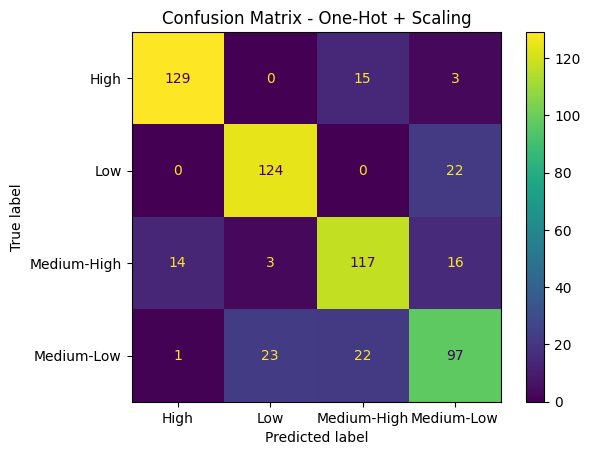

In [225]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

X_alt = X_cat.copy()

bool_cols = X_alt.select_dtypes(include=['bool']).columns
X_alt[bool_cols] = X_alt[bool_cols].astype('object')

categorical_cols = [c for c in X_alt.columns if X_alt[c].dtype == 'object']
numeric_cols = X_alt.select_dtypes(include=[np.number]).columns.tolist()

X_ohe = pd.get_dummies(X_alt, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
numeric_cols_in_ohe = [c for c in numeric_cols if c in X_ohe.columns]
if numeric_cols_in_ohe:
    X_ohe[numeric_cols_in_ohe] = scaler.fit_transform(X_ohe[numeric_cols_in_ohe])

print("Shape after one-hot encoding:", X_ohe.shape)

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

clf_ohe = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)
clf_ohe.fit(X_train_ohe, y_train_ohe)

y_pred_ohe = clf_ohe.predict(X_test_ohe)

print(f"Accuracy:  {accuracy_score(y_test_ohe, y_pred_ohe):.4f}")
print(f"Precision: {precision_score(y_test_ohe, y_pred_ohe, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_ohe, y_pred_ohe, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_ohe, y_pred_ohe, average='weighted'):.4f}")

ConfusionMatrixDisplay.from_predictions(y_test_ohe, y_pred_ohe, display_labels=y_encoder.classes_)
plt.title("Confusion Matrix - One-Hot + Scaling")
plt.show()

The result of using the label encoding is the following:

Accuracy:  0.8294
Precision: 0.8312
Recall:    0.8294
F1 Score:  0.8298

The result of the one hot encoding is the following:

Accuracy:  0.7969
Precision: 0.7967
Recall:    0.7969
F1 Score:  0.7967


In this case one hot encoding increases the dataframe size, but does not increase the overall performance of the model. The decrease in performance when ohe is used could stem from the high amount of columns that were created. 

There can still be a possibility of the label encoding having a false ordinal dataset(for example the feature "Land Contour" does not necesarily invoke ordinality). A mix of both encodings could prove useful in improving the model.


In [226]:
param_grid = [
    {'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.1},
    {'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.05},
    {'max_depth': 6, 'n_estimators': 100, 'learning_rate': 0.1},
    {'max_depth': 9, 'n_estimators': 100, 'learning_rate': 0.1},
    {'max_depth': 6, 'n_estimators': 200, 'learning_rate': 0.01},
    {'max_depth': 12, 'n_estimators': 100, 'learning_rate': 0.05},
]

for p in param_grid:
    clf_hp = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y_encoded)),
        max_depth=p['max_depth'],
        learning_rate=p['learning_rate'],
        n_estimators=p['n_estimators'],
        random_state=42,
        eval_metric='mlogloss'
    )
    clf_hp.fit(X_train_20, y_train_20)
    y_pred_hp = clf_hp.predict(X_test_20)

    acc = accuracy_score(y_test_20, y_pred_hp)
    f1v = f1_score(y_test_20, y_pred_hp, average='weighted')
    rec = recall_score(y_test_20, y_pred_hp, average='weighted')
    prec = precision_score(y_test_20, y_pred_hp, average='weighted')

    print(f"max_depth={p['max_depth']}, n_estimators={p['n_estimators']}, lr={p['learning_rate']} → acc={acc:.4f}, f1={f1v:.4f}, rec={rec:.4f}, prec={prec:.4f}")

max_depth=3, n_estimators=50, lr=0.1 → acc=0.7799, f1=0.7783, rec=0.7799, prec=0.7776
max_depth=3, n_estimators=200, lr=0.05 → acc=0.8003, f1=0.7997, rec=0.8003, prec=0.7992
max_depth=3, n_estimators=200, lr=0.05 → acc=0.8003, f1=0.7997, rec=0.8003, prec=0.7992
max_depth=6, n_estimators=100, lr=0.1 → acc=0.8072, f1=0.8062, rec=0.8072, prec=0.8056
max_depth=6, n_estimators=100, lr=0.1 → acc=0.8072, f1=0.8062, rec=0.8072, prec=0.8056
max_depth=9, n_estimators=100, lr=0.1 → acc=0.8003, f1=0.8006, rec=0.8003, prec=0.8010
max_depth=9, n_estimators=100, lr=0.1 → acc=0.8003, f1=0.8006, rec=0.8003, prec=0.8010
max_depth=6, n_estimators=200, lr=0.01 → acc=0.7799, f1=0.7784, rec=0.7799, prec=0.7777
max_depth=6, n_estimators=200, lr=0.01 → acc=0.7799, f1=0.7784, rec=0.7799, prec=0.7777
max_depth=12, n_estimators=100, lr=0.05 → acc=0.8038, f1=0.8040, rec=0.8038, prec=0.8044
max_depth=12, n_estimators=100, lr=0.05 → acc=0.8038, f1=0.8040, rec=0.8038, prec=0.8044


The model achieves the best performance with hyperparameters set to max_depth = 6, n_estimators = 100, and learning rate = 0.1. A tree of depth 6 strikes the right balance between capturing complex patterns in the data and avoiding overfitting. Shallow trees (depth=3) lack the capacity to model intricate relationships, while deeper trees (depth > 6) tend to memorize noise, leading to poor generalization. The learning rate of 0.1 offers a good pace for the model to learn without overshooting optimal solutions. Increasing the number of estimators helps when paired with a reasonable learning rate, but after a certain point, more trees offer diminishing returns and can even lead to overfitting.

Overall, the optimal configuration of depth, estimators, and learning rate allows the model to effectively balance complexity and generalization, avoiding both underfitting and overfitting.
